In [1]:
# from data import _read_cvrp, _read_distance, create_random_cvrp
from map import Map
from cluster import Cluster
import pandas as pd
import numpy as np
import solver as sl
import matplotlib.pyplot as plt
from distance import *
import itertools as itter
import heapq


%load_ext autoreload
%autoreload 2


# data, meta_data = _read_cvrp('sample_data/X-n5.vrp')
# print(meta_data)
# data

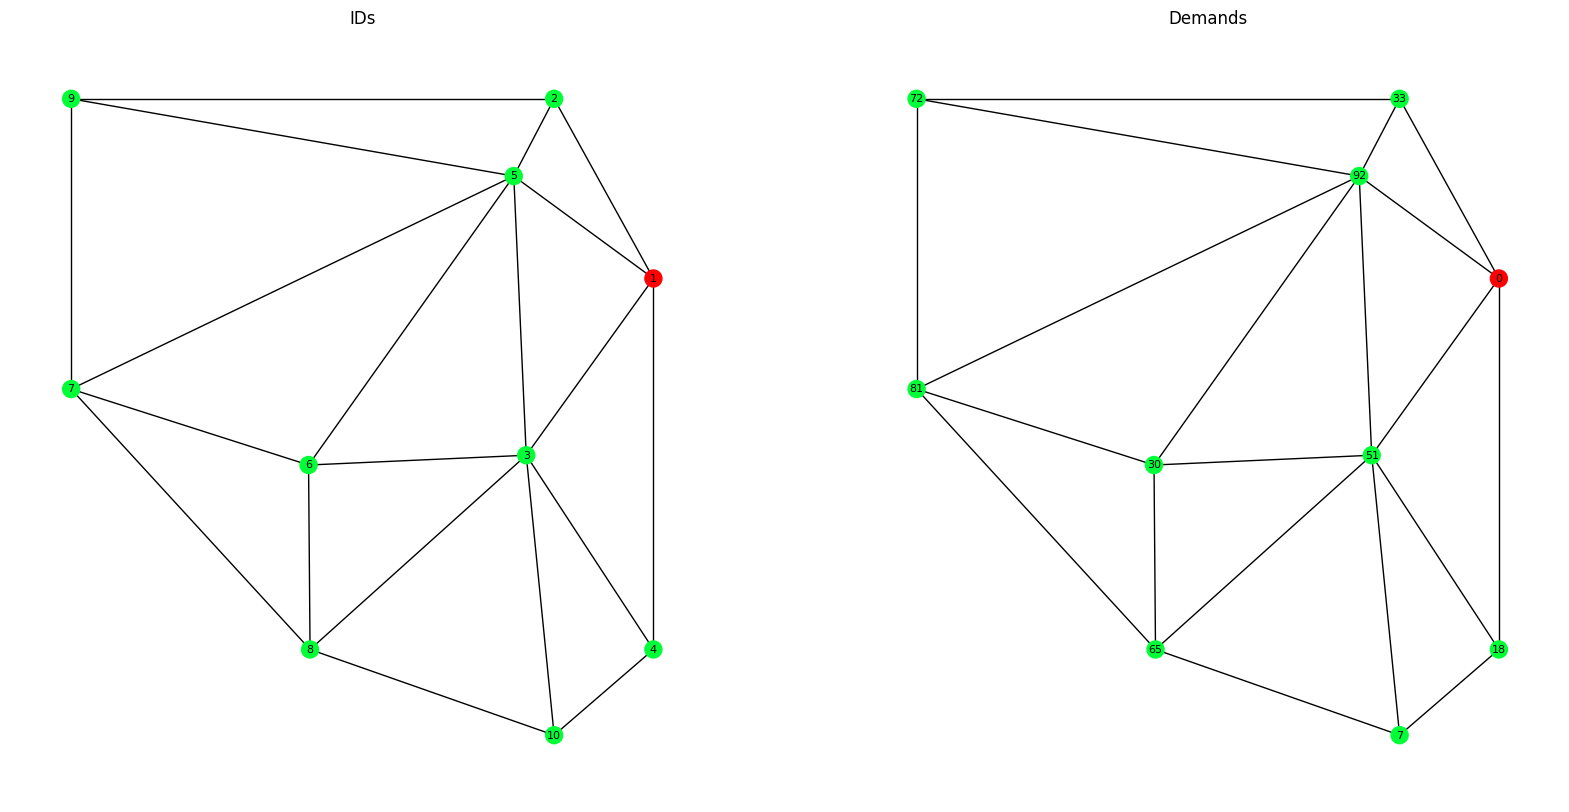

In [168]:
map = Map(seed=10)
# map.import_nodes_from_file('sample_data/X-n5.vrp', 'cvrp')
# map.import_nodes_from_file('sample_data/X-n101-k25.vrp', 'cvrp')
# map.import_nodes_from_file('sample_data/X-n1001-k43.vrp', 'cvrp')
map.create_random_nodes(n=10)
# map.create_random_nodes(n=60, depots=[1,6,21])
map.create_net_by_voronoi()

fig, ax = plt.subplots(1, 2, figsize=(20,10))
map.plot(node_label='id',ax=ax[0])
map.plot(node_label='demand',ax=ax[1])
_ = ax[0].set_title('IDs')
_ = ax[1].set_title('Demands')


In [152]:
# n1:Node
# n2:Node
# n1, n2 = map.farthest_nodes()
# print(f"n1: {n1.id}, n2: {n2.id}")
# print(f"n1 demand: {n1.demand}, n2 demand: {n2.demand}")

In [169]:
import networkx as nx
from sklearn.cluster import AgglomerativeClustering

In [175]:
# connectivity = nx.to_pandas_adjacency(map.network)
adj = nx.to_pandas_adjacency(map.network, weight='dist_demand')
adj

,1,2,3,4,5,6,7,8,9,10
1,0.000000,0.883102,0.825206,0.934440,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.883102,0.000000,0.000000,0.000000,0.800708,0.000000,0.000000,0.000000,0.863366,0.000000
3,0.825206,0.000000,0.000000,0.883102,0.856885,0.923939,0.000000,0.948627,0.000000,0.847256
4,0.934440,0.000000,0.883102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.959409
5,0.707107,0.800708,0.856885,0.000000,0.000000,0.791710,0.959409,0.000000,0.927426,0.000000
6,0.000000,0.000000,0.923939,0.000000,0.791710,0.000000,0.825206,0.876474,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.959409,0.825206,0.000000,0.941507,0.966664,0.000000
8,0.000000,0.000000,0.948627,0.000000,0.000000,0.876474,0.941507,0.000000,0.000000,0.803730
9,0.000000,0.863366,0.000000,0.000000,0.927426,0.000000,0.966664,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.847256,0.959409,0.000000,0.000000,0.000000,0.803730,0.000000,0.000000


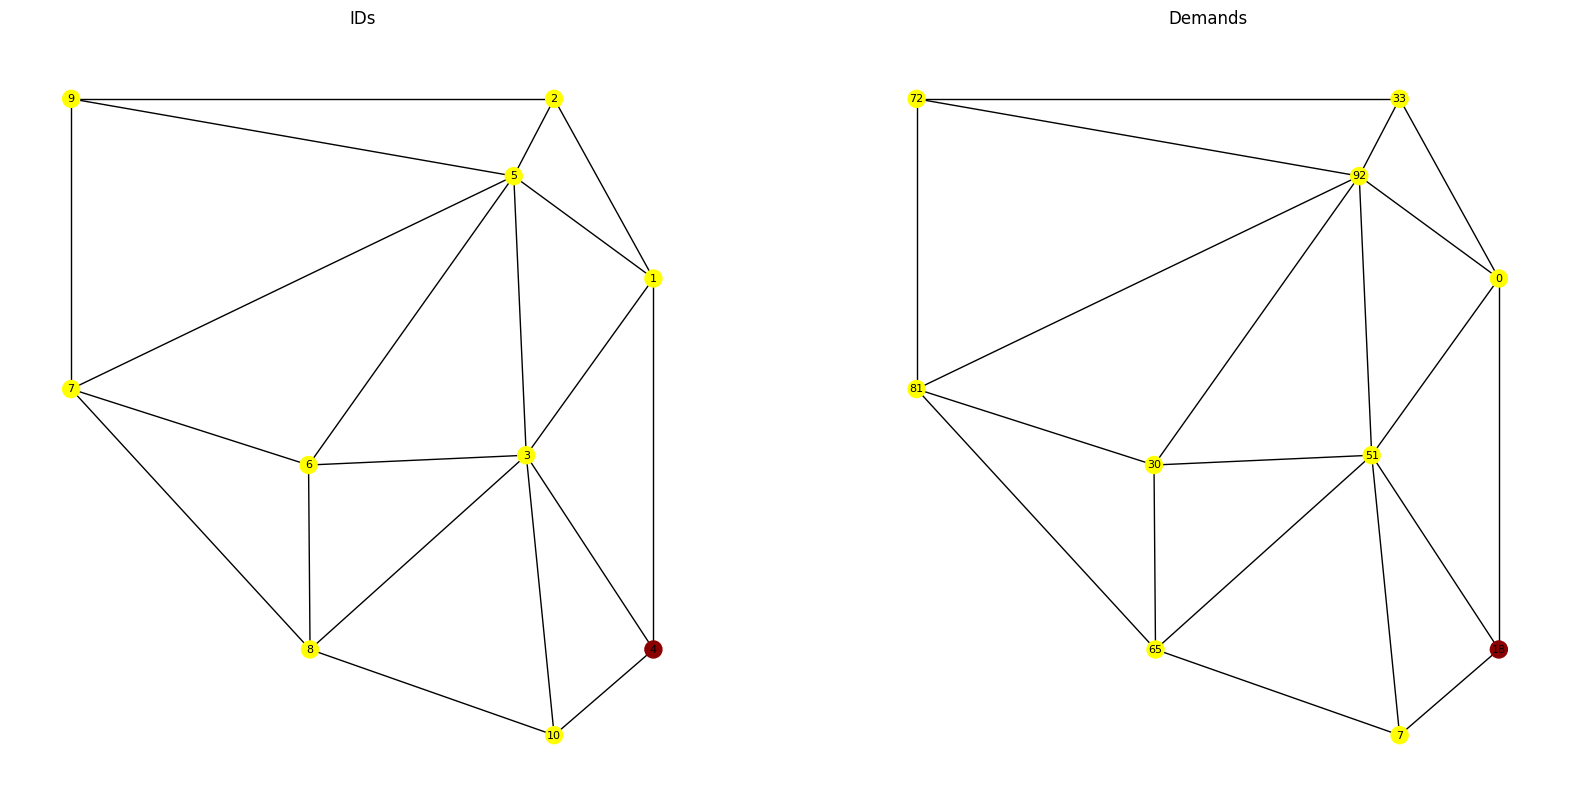

In [187]:
clustering = AgglomerativeClustering(n_clusters=2,metric='precomputed',linkage='single',connectivity=adj, compute_distances=True)
cls = clustering.fit_predict(adj)
for idx, c in enumerate(cls):
    map.nodes[idx].cluster_idx=c

fig, ax = plt.subplots(1, 2, figsize=(20,10))
map.plot(node_label='id', node_color='cluster',ax=ax[0])
map.plot(node_label='demand', node_color='cluster',ax=ax[1])
_ = ax[0].set_title('IDs')
_ = ax[1].set_title('Demands')

In [177]:
clustering.distances_

array([0.70710678, 0.79170973, 0.80372987, 0.84190497, 0.86867673,
       0.88076721, 0.91141102, 0.92788127, 0.93423991])

In [179]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

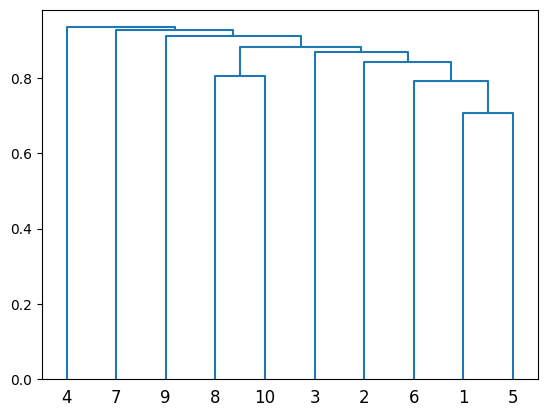

In [185]:
plot_dendrogram(clustering, labels=map.nodes)

In [291]:
connectivity = nx.to_pandas_adjacency(map.network)
connectivity = np.array(connectivity)

cluster_net = nx.Graph()
for n in map.network.nodes():
    cluster_net.add_node(Cluster(n))

ordered=[]
for c in itter.combinations(cluster_net.nodes(), r=2):
    n1, n2 = c[0], c[1]
    if (connectivity[n1.index, n2.index]):
        diff = np.abs(n1.total_demand - n2.total_demand)
        cluster_net.add_edge(n1, n2, diff= diff)
        heapq.heappush(ordered, (-diff, (n1, n2)))

In [292]:
ordered

[(-92,
  (<cluster.Cluster at 0x271990b1950>, <cluster.Cluster at 0x27199102d90>)),
 (-59,
  (<cluster.Cluster at 0x27194646250>, <cluster.Cluster at 0x27199102d90>)),
 (-62,
  (<cluster.Cluster at 0x27199102d90>, <cluster.Cluster at 0x27199102e10>)),
 (-51,
  (<cluster.Cluster at 0x27199102e10>, <cluster.Cluster at 0x27197c96f10>)),
 (-58,
  (<cluster.Cluster at 0x271990b5a50>, <cluster.Cluster at 0x2719910ef50>)),
 (-39,
  (<cluster.Cluster at 0x27194646250>, <cluster.Cluster at 0x27196c1fb90>)),
 (-33,
  (<cluster.Cluster at 0x271990e31d0>, <cluster.Cluster at 0x271990e3d90>)),
 (-41,
  (<cluster.Cluster at 0x271990e31d0>, <cluster.Cluster at 0x27199102d90>)),
 (-21,
  (<cluster.Cluster at 0x271990e31d0>, <cluster.Cluster at 0x27199102e10>)),
 (-51,
  (<cluster.Cluster at 0x271990b1950>, <cluster.Cluster at 0x271990e31d0>)),
 (-44,
  (<cluster.Cluster at 0x271990e31d0>, <cluster.Cluster at 0x2719910ef50>)),
 (-11,
  (<cluster.Cluster at 0x271990e3d90>, <cluster.Cluster at 0x2719910e